In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import geopy
from geopy import distance

%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import importlib

In [2]:
#download the ECCO grid file

from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                    StartDate="2000-01-09",EndDate="2000-01-14",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '2000-01-09,2000-01-14'}

Total number of matching granules: 1

GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|#########################| 1/1 [00:00<00:00, 9845.78it/s]

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s


In [3]:
# download file (granule) containing 2000 velocities,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"
ecco_podaac_download(ShortName=vel_monthly_shortname,\
                    StartDate="2000-01-02",EndDate="2000-12-31",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2000-01-02,2000-12-31'}

Total number of matching granules: 12

OCEAN_VELOCITY_mon_mean_2000-02_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-03_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-04_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-05_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-06_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-07_ECCO_V4r4_native_llc0090.nc already exist

In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

In [7]:
## Load vector fields
ecco_vars = xr.open_mfdataset(join(ECCO_dir,'*OCEAN*VEL*MONTHLY*','*_2000-*.nc'))

ecco_ds = []

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars)).load()

pprint(ecco_ds.data_vars)

Data variables:
    CS       (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN       (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    rA       (tile, j, i) float32 3.623e+08 3.633e+08 ... 3.685e+08 3.611e+08
    dxG      (tile, j_g, i) float32 1.558e+04 1.559e+04 ... 2.36e+04 2.314e+04
    dyG      (tile, j, i_g) float32 2.321e+04 2.327e+04 ... 1.56e+04 1.558e+04
    Depth    (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rAz      (tile, j_g, i_g) float32 1.799e+08 1.805e+08 ... 3.642e+08
    dxC      (tile, j, i_g) float32 1.558e+04 1.559e+04 ... 2.387e+04 2.341e+04
    dyC      (tile, j_g, i) float32 1.156e+04 1.159e+04 ... 1.559e+04 1.558e+04
    rAw      (tile, j, i_g) float32 3.617e+08 3.628e+08 ... 3.722e+08 3.648e+08
    rAs      (tile, j_g, i) float32 1.802e+08 1.807e+08 ... 3.678e+08 3.605e+08
    drC      (k_p1) float32 5.0 10.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.2
    drF      (k) float32 10.0 10.0 10.0 1

In [8]:
#create arrays for zonal and meridional components of velocities over depths
#Nz: vertical level; Nh: horizontal level
Nz = 25
Nh = 20

UVEL_slice = np.zeros((Nz, Nh))
VVEL_slice = np.zeros((Nz, Nh))
lat_slice  = np.zeros((Nz, Nh))
lon_slice  = np.zeros((Nz, Nh))

In [9]:
#interpolation along a line transect

delta_lat = 0.25
delta_lon = 0.25

for i in range (0, Nh):
    for j in range (0, Nz):

        new_grid_min_lat = 35.625 + delta_lat * i
        new_grid_max_lat = 36.125 + delta_lat * i

        new_grid_min_lon = -69.375 - delta_lon * i
        new_grid_max_lon = -68.875 - delta_lon * i

        xfld = ecco_ds.UVEL.isel(k=j, time=0)
        yfld = ecco_ds.VVEL.isel(k=j, time=0)

        # Compute the zonal and meridional vector components of oceTAUX and oceTAUY
        oceVEL_E, oceVEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)

        # interpolate to lat-lon
        new_grid_lon_centers, new_grid_lat_centers,\
        new_grid_lon_edges, new_grid_lat_edges,\
        oceVEL_E_latlon =\
                ecco.resample_to_latlon(ecco_grid.XC, \
                                        ecco_grid.YC, \
                                        oceVEL_E,\
                                        new_grid_min_lat, new_grid_max_lat, delta_lat,\
                                        new_grid_min_lon, new_grid_max_lon, delta_lon,\
                                        fill_value = np.NaN, \
                                        mapping_method = 'nearest_neighbor',
                                        radius_of_influence = 120000)
        
        new_grid_lon_centers, new_grid_lat_centers,\
        new_grid_lon_edges, new_grid_lat_edges,\
        oceVEL_N_latlon =\
                ecco.resample_to_latlon(ecco_grid.XC, \
                                        ecco_grid.YC, \
                                        oceVEL_N,\
                                        new_grid_min_lat, new_grid_max_lat, delta_lat,\
                                        new_grid_min_lon, new_grid_max_lon, delta_lon,\
                                        fill_value = np.NaN, \
                                        mapping_method = 'nearest_neighbor',
                                        radius_of_influence = 120000)
        UVEL_slice[j, i] = oceVEL_E_latlon[1, 1]
        VVEL_slice[j, i] = oceVEL_N_latlon[1, 1]
        lat_slice[j, i]  = new_grid_lat_centers[1, 1]
        lon_slice[j, i]  = new_grid_lon_centers[1, 1]

In [10]:
#calculate speed
speed_slice = np.zeros((Nz, Nh))

for i in range (0, Nh):
    for j in range (0, Nz):
        speed_slice[j, i] = np.sqrt(UVEL_slice[j, i]**2 + VVEL_slice[j, i]**2)

In [12]:
#To get the distance array
distance_slice = np.zeros(Nh)
for i in range(0, Nh-1):
    start_point = (36, -69)
    end_point = (36.25 + i * delta_lat, -69.25 - i * delta_lon)
    distance_slice[i + 1] = distance.distance(start_point, end_point).km

In [13]:
#To get a depth array
depth_slice = ecco_grid.Z[0:25]

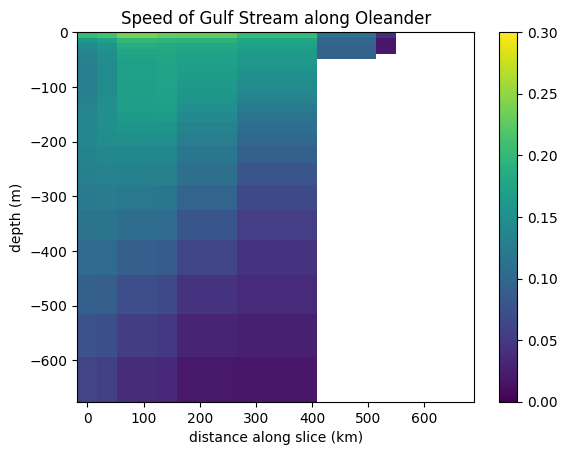

In [14]:
#plot

fig, ax = plt.subplots()

im = ax.pcolormesh(distance_slice, depth_slice, speed_slice, vmin=0, vmax=0.3)
plt.colorbar(im)
plt.xlabel('distance along slice (km)')
plt.ylabel('depth (m)')
plt.title('Speed of Gulf Stream along Oleander')
plt.show()